# Setting Up Kaggle API Credentials

In [8]:
import shutil
import os

# Your actual path to kaggle.json
kaggle_path = os.path.expanduser("~/.kaggle/kaggle.json")
dest_dir = os.path.expanduser("~/.kaggle")
dest_file = os.path.join(dest_dir, "kaggle.json")

# Ensure the .kaggle directory exists
os.makedirs(dest_dir, exist_ok=True)

# Only copy if the paths are different
if os.path.abspath(kaggle_path) != os.path.abspath(dest_file):
    shutil.copy(kaggle_path, dest_file)

# Set permissions (optional on Windows)
try:
    os.chmod(dest_file, 0o600)
except PermissionError:
    pass


# Importing Libraries and Models

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import joblib
from skimage.feature import local_binary_pattern
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectFromModel

import seaborn as sns
from tqdm import tqdm
from sklearn.manifold import TSNE
import umap
from xgboost import XGBClassifier

d:\Anaconda\envs\ML_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading Pre-trained VGG16 Model for Feature Extraction

In [3]:
cnn_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [1]:
def extract_all_features(image_path):
    try:
        img = cv2.imread(image_path)
        if img is None:
            return None
        img_resized = cv2.resize(img, (224, 224))

        # HSV Color Histogram
        hsv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)
        hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8],
                            [0, 180, 0, 256, 0, 256])
        color_feat = cv2.normalize(hist, hist).flatten()

        # LBP Texture
        gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
        (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
        texture_feat = lbp_hist.astype("float") / (lbp_hist.sum() + 1e-7)

        # ✅ Canny Edge Detection Feature
        edges = cv2.Canny(gray, threshold1=100, threshold2=200)
        edge_mean = np.mean(edges) / 255.0  # normalize to [0,1]
        edge_sum = np.sum(edges) / (224 * 224 * 255.0)  # percentage of edge pixels
        edge_feat = np.array([edge_mean, edge_sum])

        # CNN (deep) features
        img_array = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
        x = image.img_to_array(img_array)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        cnn_feat = cnn_model.predict(x, verbose=0).flatten()

        # Combine all features
        return np.concatenate([color_feat, texture_feat, edge_feat, cnn_feat])

    except Exception as e:
        print(f"❌ Error processing {image_path}: {e}")
        return None


In [2]:
dataset_dir = 'D:\OneDrive - American International University-Bangladesh\SemesterVIII\Final VIII\Machine Learning\FireDetectionMeheraj\FireDatasetPCD\Train'
classes = ['Fire', 'Neutral']

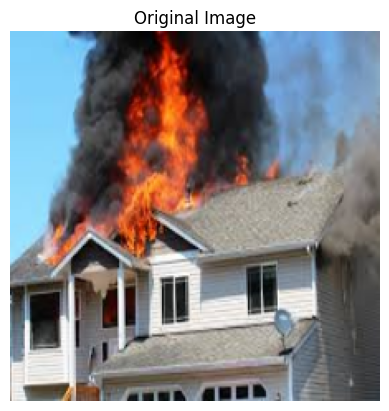

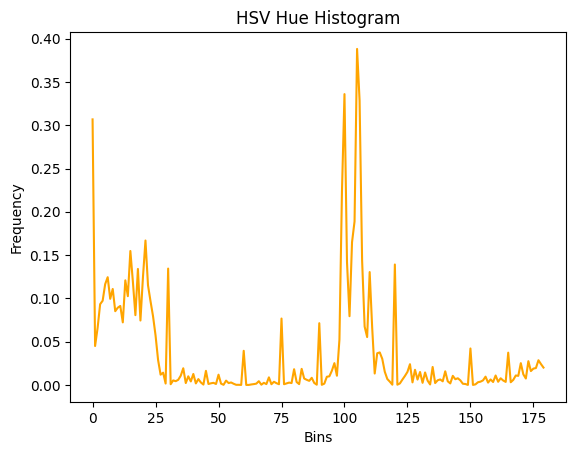

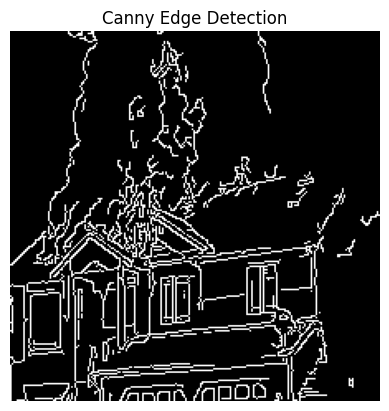

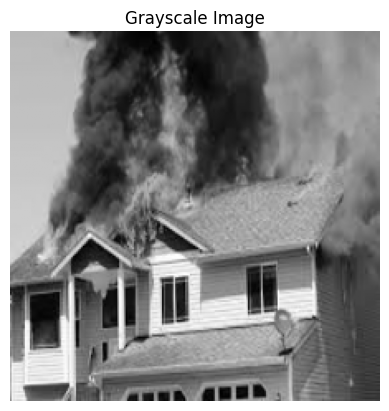

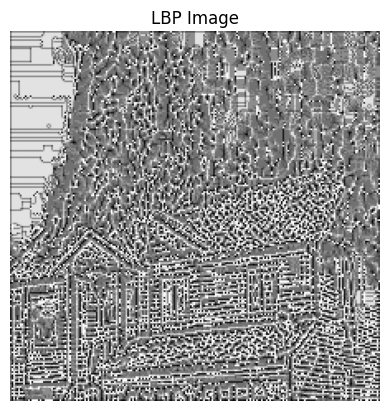

In [12]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.feature import local_binary_pattern

# Set dataset path and class
dataset_dir = r'D:\OneDrive - American International University-Bangladesh\SemesterVIII\Final VIII\Machine Learning\FireDetectionMeheraj\FireDatasetPCD\Train'
fire_dir = os.path.join(dataset_dir, 'Fire')

# Pick a random image
random_image_name = random.choice(os.listdir(fire_dir))
random_image_path = os.path.join(fire_dir, random_image_name)

# Load and process image
img = cv2.imread(random_image_path)
img_resized = cv2.resize(img, (224, 224))
gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

# 1. Original Image
plt.figure()
plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")
plt.savefig("original_image.jpg")
plt.show()

# 2. HSV Hue Histogram
hsv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)
hue_hist = cv2.calcHist([hsv], [0], None, [180], [0, 180])
hue_hist = cv2.normalize(hue_hist, hue_hist).flatten()

plt.figure()
plt.plot(hue_hist, color='orange')
plt.title("HSV Hue Histogram")
plt.xlabel("Bins")
plt.ylabel("Frequency")
plt.savefig("hue_histogram.jpg")
plt.show()

# 3. Canny Edge Detection
edges = cv2.Canny(gray, 100, 200)
plt.figure()
plt.imshow(edges, cmap='gray')
plt.title("Canny Edge Detection")
plt.axis("off")
plt.savefig("canny_edges.jpg")
plt.show()

# 4. Grayscale Image
plt.figure()
plt.imshow(gray, cmap='gray')
plt.title("Grayscale Image")
plt.axis("off")
plt.savefig("grayscale.jpg")
plt.show()

# 5. LBP Image
lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
lbp_uint8 = np.uint8(255 * lbp / lbp.max())
plt.figure()
plt.imshow(lbp_uint8, cmap='gray')
plt.title("LBP Image")
plt.axis("off")
plt.savefig("lbp_image.jpg")
plt.show()


In [ ]:
features = []
labels = []

for label in classes:
    folder = os.path.join(dataset_dir, label)
    if not os.path.exists(folder):
        print(f"❌ Folder not found: {folder}")
        continue
    print(f"✅ Processing: {folder}")

    for fname in tqdm(os.listdir(folder), desc=f"Scanning {label}"):
        fpath = os.path.join(folder, fname)
        if not os.path.isfile(fpath):
            continue
        feats = extract_all_features(fpath)
        if feats is not None:
            features.append(feats)
            labels.append(1 if label == 'Fire' else 0)

✅ Processing: D:\OneDrive - American International University-Bangladesh\SemesterVIII\Final VIII\Machine Learning\FireDetectionMeheraj\FireDatasetPCD\Train\Fire


Scanning Fire: 100%|██████████| 987/987 [01:21<00:00, 12.11it/s]


✅ Processing: D:\OneDrive - American International University-Bangladesh\SemesterVIII\Final VIII\Machine Learning\FireDetectionMeheraj\FireDatasetPCD\Train\Neutral


Scanning Neutral:  42%|████▏     | 556/1333 [00:46<01:03, 12.18it/s]Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x0000011928521240>
Traceback (most recent call last):
  File "d:\Anaconda\envs\ML_env\lib\weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 
Scanning Neutral:  53%|█████▎    | 701/1333 [00:58<00:50, 12.55it/s]

In [ ]:
# Convert lists to numpy arrays
features = np.array(features)
labels = np.array(labels)

# Define the file paths where the arrays will be saved
features_path = 'D:/OneDrive - American International University-Bangladesh/SemesterVIII/Final VIII/Machine Learning/FireDetectionMeheraj/fire_image_features.npy'
labels_path = 'D:/OneDrive - American International University-Bangladesh/SemesterVIII/Final VIII/Machine Learning/FireDetectionMeheraj/fire_image_labels.npy'

# Save the features and labels
np.save(features_path, features)
np.save(labels_path, labels)

print(f"✅ Feature Shape: {features.shape}")
print(f"🔥 Fire images: {np.sum(labels == 1)}, ❄️ Neutral images: {np.sum(labels == 0)}")

✅ Feature Shape: (2319, 25609)
🔥 Fire images: 987, ❄️ Neutral images: 1332


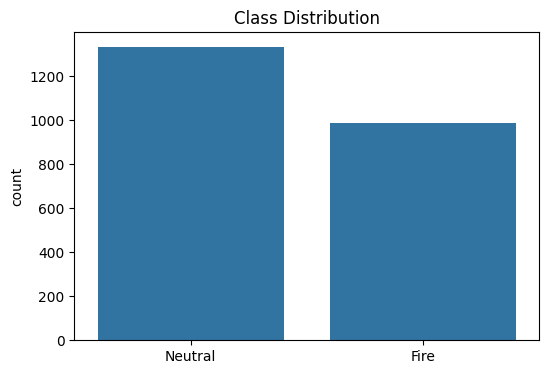

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x=labels)
plt.title("Class Distribution")
plt.xticks([0, 1], ['Neutral', 'Fire'])
plt.show()

In [ ]:
X = np.load('D:/OneDrive - American International University-Bangladesh/SemesterVIII/Final VIII/Machine Learning/FireDetectionMeheraj/fire_image_features.npy')
y = np.load('D:/OneDrive - American International University-Bangladesh/SemesterVIII/Final VIII/Machine Learning/FireDetectionMeheraj/fire_image_labels.npy')

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

🔍 Classification Report:
              precision    recall  f1-score   support

     Neutral       0.97      0.96      0.97       267
        Fire       0.95      0.96      0.95       197

    accuracy                           0.96       464
   macro avg       0.96      0.96      0.96       464
weighted avg       0.96      0.96      0.96       464

✅ Accuracy: 0.9612068965517241
✅ F1 Score: 0.9547738693467337


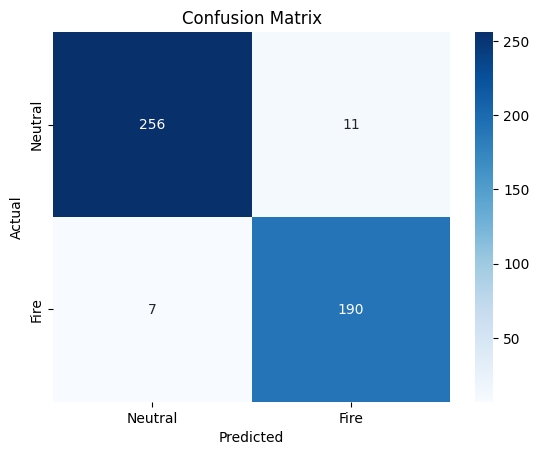

💾 Model saved successfully.


In [ ]:
print("🔍 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Neutral", "Fire"]))

# Accuracy and F1 Score
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("✅ F1 Score:", f1_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Neutral", "Fire"], yticklabels=["Neutral", "Fire"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Save the trained model
joblib.dump(clf, r'D:\OneDrive - American International University-Bangladesh\SemesterVIII\Final VIII\Machine Learning\FireDetectionMeheraj\random_forest_fire_model.pkl')
print("💾 Model saved successfully.")

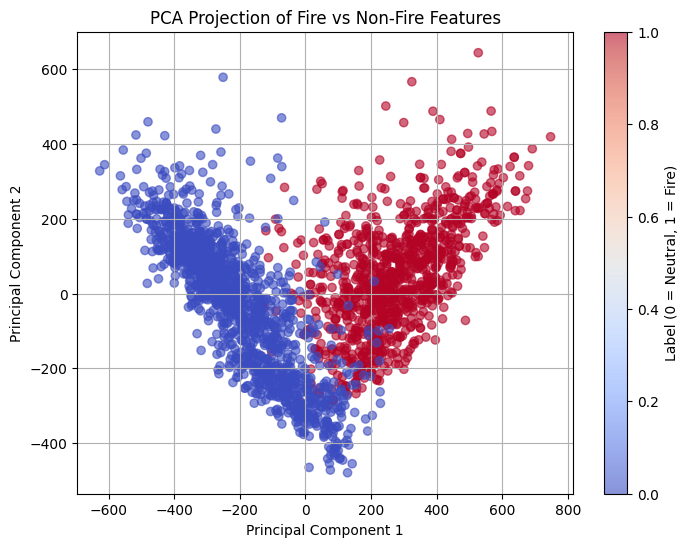

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced_pca = pca.fit_transform(features)

plt.figure(figsize=(8,6))
plt.scatter(reduced_pca[:, 0], reduced_pca[:, 1], c=labels, cmap='coolwarm', alpha=0.6)
plt.title("PCA Projection of Fire vs Non-Fire Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.colorbar(label='Label (0 = Neutral, 1 = Fire)')
plt.show()

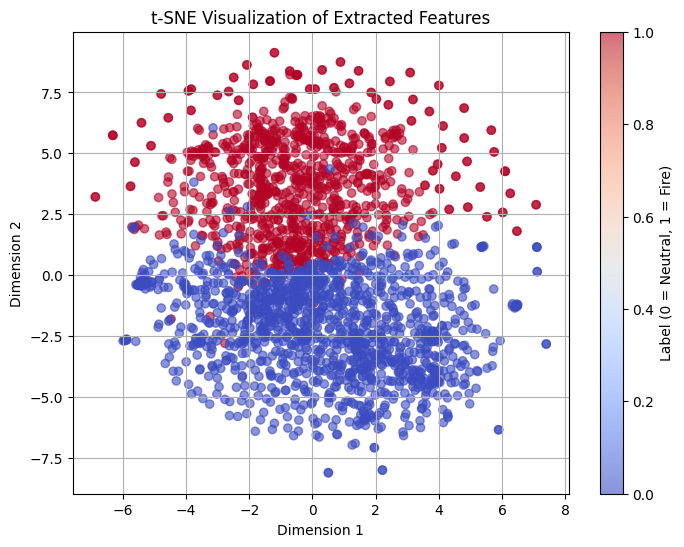

In [ ]:
# Ensure features is a NumPy array
features = np.array(features)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
reduced_tsne = tsne.fit_transform(features)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(reduced_tsne[:, 0], reduced_tsne[:, 1], c=labels, cmap='coolwarm', alpha=0.6)
plt.title("t-SNE Visualization of Extracted Features")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.colorbar(label='Label (0 = Neutral, 1 = Fire)')
plt.show()


d:\Anaconda\envs\ML_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


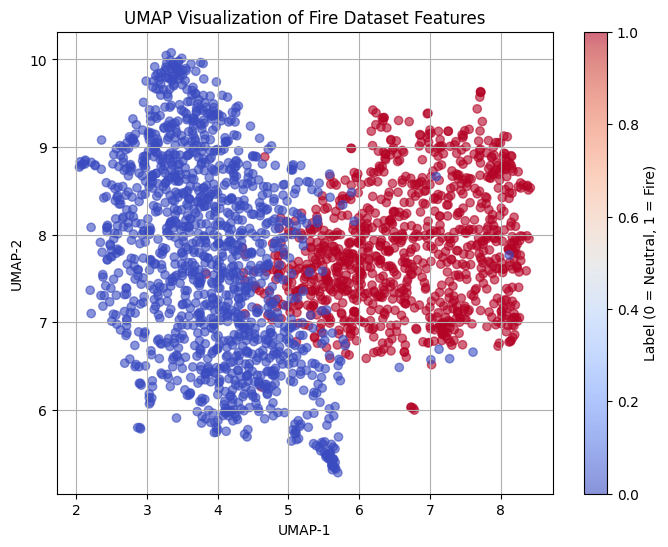

In [ ]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
reduced_umap = reducer.fit_transform(features)

plt.figure(figsize=(8,6))
plt.scatter(reduced_umap[:, 0], reduced_umap[:, 1], c=labels, cmap='coolwarm', alpha=0.6)
plt.title("UMAP Visualization of Fire Dataset Features")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.colorbar(label='Label (0 = Neutral, 1 = Fire)')
plt.show()


In [ ]:
# Load features and labels
X = np.load('fire_image_features.npy')
y = np.load('fire_image_labels.npy')

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SelectKBest
selector = SelectKBest(score_func=f_classif, k=50)  # You can adjust 'k'
X_new = selector.fit_transform(X_scaled, y)

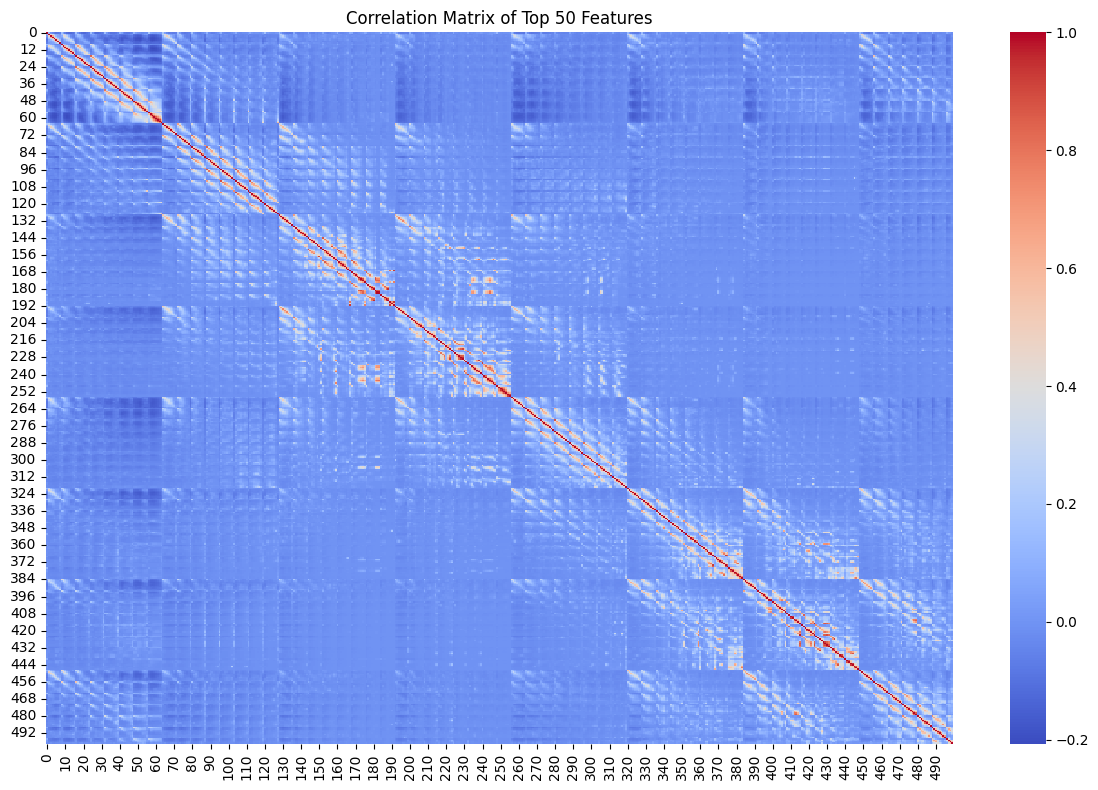

In [ ]:
# Limit to first 50 features (or fewer)
subset_features = np.array(features)[:, :500]  # Adjust this as needed

df_subset = pd.DataFrame(subset_features)
corr_matrix = df_subset.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')  # Turn off annot for speed
plt.title("Correlation Matrix of Top 50 Features")
plt.tight_layout()
plt.show()

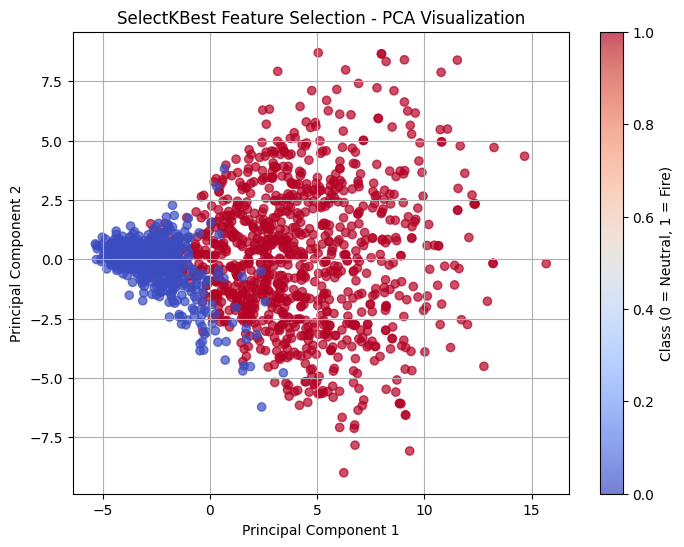

In [ ]:
# Reduce to 2D with PCA for visualization
pca_kbest = PCA(n_components=2)
X_kbest_pca = pca_kbest.fit_transform(X_new)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_kbest_pca[:, 0], X_kbest_pca[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
plt.title("SelectKBest Feature Selection - PCA Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.colorbar(label='Class (0 = Neutral, 1 = Fire)')
plt.show()

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\xgboost\training.py:183: UserWarning: [15:59:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\xgboost\sklearn.py:1478: UserWarning: [15:59:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  score = b.get_score(


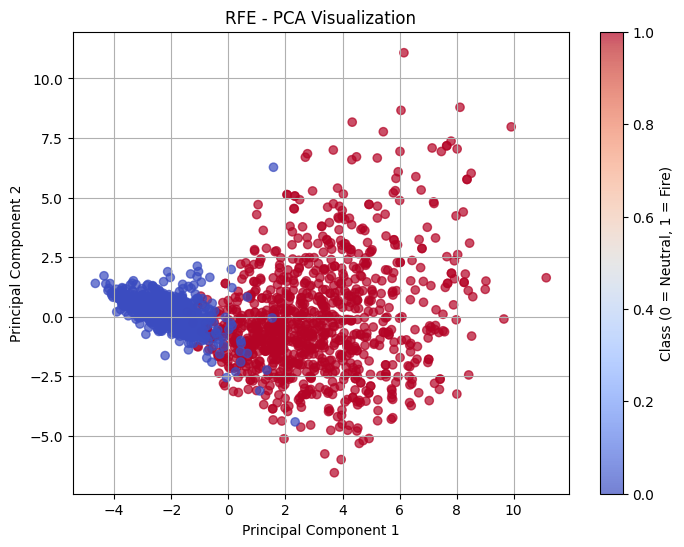

In [ ]:

# Load your data
X = np.load('D:/OneDrive - American International University-Bangladesh/SemesterVIII/Final VIII/Machine Learning/FireDetectionMeheraj/fire_image_features.npy')
y = np.load('D:/OneDrive - American International University-Bangladesh/SemesterVIII/Final VIII/Machine Learning/FireDetectionMeheraj/fire_image_labels.npy')

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train XGBoost model for feature importance with GPU support
model = XGBClassifier(
    eval_metric='mlogloss', 
    random_state=42,
    tree_method='gpu_hist',  # Use GPU for training
    gpu_id=0  # Use the first GPU (change if needed)
)

model.fit(X_scaled, y)

# Select features based on importance (top 50 features using 'weight' importance type)
selector = SelectFromModel(model, max_features=50, importance_getter='auto')  # Use 'auto' for best feature importance type
X_selected = selector.transform(X_scaled)

# Reduce to 2D with PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_selected)

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.7)
plt.title("RFE - PCA Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.colorbar(label='Class (0 = Neutral, 1 = Fire)')
plt.show()


In [ ]:
# This gives a boolean mask of selected features
selected_mask = selector.get_support()

# Get the indices of the selected features
selected_indices = np.where(selected_mask)[0]

print(f"Total selected features: {len(selected_indices)}")
print("Selected feature indices:", selected_indices)


Total selected features: 50
Selected feature indices: [    6    44    47   219   512   519   775  1011  1085  1144  1465  1684
  1897  2101  2195  2442  2492  4756  5173  5248  5268  5685  5780  6321
  6621  6804  8757  8967  9269  9708  9781 10293 10588 12534 12853 14326
 15030 15413 15925 16775 16949 18604 18997 19325 20150 21557 22968 23212
 23933 24080]
